In [107]:
import numpy as np
import pandas as pd

In [308]:
df=pd.read_csv('data/clean/master_df.csv')

In [309]:
df.sample(5)

,Unnamed: 0,Employee_ID,Teams_Messages_Sent_sum,Teams_Messages_Sent_mean,Teams_Messages_Sent_median,Teams_Messages_Sent_std,Emails_Sent_sum,Emails_Sent_mean,Emails_Sent_median,Emails_Sent_std,...,Manager_Feedback,Promotion_Consideration,Last_Review_Period,Last_Review_Year,Best Team Player_Count,Innovation Award_Count,Leadership Excellence_Count,Star Performer_Count,Total_Decayed_Reward_Points,Decayed_Vibe
292,292,EMP0295,15.0,15.0,15.0,0.000000,13.0,13.0,13.0,0.000000,...,Exceeds Expectations,True,H2,2023.0,NaN,NaN,NaN,NaN,NaN,NaN
402,402,EMP0406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.015622
310,310,EMP0313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,24.811126,NaN
351,351,EMP0354,25.0,25.0,25.0,0.000000,5.0,5.0,5.0,0.000000,...,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,21.701300,3.576690
4,4,EMP0005,27.0,13.5,13.5,3.535534,32.0,16.0,16.0,16.970563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.263700


In [310]:
df.columns

Index(['Unnamed: 0', 'Employee_ID', 'Teams_Messages_Sent_sum',
       'Teams_Messages_Sent_mean', 'Teams_Messages_Sent_median',
       'Teams_Messages_Sent_std', 'Emails_Sent_sum', 'Emails_Sent_mean',
       'Emails_Sent_median', 'Emails_Sent_std', 'Meetings_Attended_sum',
       'Meetings_Attended_mean', 'Meetings_Attended_median',
       'Meetings_Attended_std', 'Work_Hours_sum', 'Work_Hours_mean',
       'Work_Hours_median', 'Work_Hours_std', 'Last_activity_entry',
       'Total_activity_entry', 'Annual Leave_Factor', 'Casual Leave_Factor',
       'Sick Leave_Factor', 'Unpaid Leave_Factor', 'Joining_Date',
       'Onboarding_Feedback', 'Mentor_Assigned', 'Initial_Training_Completed',
       'Days_Since_Joining', 'Onboarding_Factor', 'Performance_Rating',
       'Manager_Feedback', 'Promotion_Consideration', 'Last_Review_Period',
       'Last_Review_Year', 'Best Team Player_Count', 'Innovation Award_Count',
       'Leadership Excellence_Count', 'Star Performer_Count',
       'Total_D

In [311]:
df.shape

(497, 41)

In [312]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [313]:
onboarding_map = {'Poor': 1, 'Average': 2, 'Excellent': 3}
df['Onboarding_Feedback_Encoded'] = df['Onboarding_Feedback'].map(onboarding_map)

rating_map = {'Poor': 1, 'Needs Improvement': 2, 'Meets Expectations': 3, 'Exceeds Expectations': 4, 'Excellent': 5}
df['Performance_Rating_Encoded'] = df['Performance_Rating'].map(rating_map)
df['Manager_Feedback_Encoded'] = df['Manager_Feedback'].map(rating_map)

bool_cols = ['Mentor_Assigned', 'Initial_Training_Completed', 'Promotion_Consideration']
for col in bool_cols:
    df[col + '_Encoded'] = df[col].map({'True': 1, 'False': 0})

In [314]:
if 'Total_activity_entry' not in df.columns:
    df['Total_activity_entry'] = np.nan

In [315]:
features = [
    #'Teams_Messages_Sent_sum', 
    'Teams_Messages_Sent_mean', 
    'Teams_Messages_Sent_median', 
    #'Teams_Messages_Sent_std',
    #'Emails_Sent_sum', 
    'Emails_Sent_mean', 
    'Emails_Sent_median', 
    #'Emails_Sent_std',
    'Meetings_Attended_sum', 
    'Meetings_Attended_mean', 
    'Meetings_Attended_median', 
    #'Meetings_Attended_std',
    #'Work_Hours_sum', 
    'Work_Hours_mean', 'Work_Hours_median', 'Work_Hours_std',
    #'Total_activity_entry',  # assuming this column exists as numeric activity count
    'Annual Leave_Factor', 'Casual Leave_Factor', 'Sick Leave_Factor', 'Unpaid Leave_Factor',
    'Days_Since_Joining', 
    'Onboarding_Factor',
    #'Last_Review_Year',
    #'Best Team Player_Count', 
    #'Innovation Award_Count', 
    #'Leadership Excellence_Count', 
    #'Star Performer_Count',
    'Total_Decayed_Reward_Points', 'Decayed_Vibe',
    'Onboarding_Feedback_Encoded', 
    #'Performance_Rating_Encoded', 
    'Manager_Feedback_Encoded',
    #'Mentor_Assigned_Encoded', 'Initial_Training_Completed_Encoded', 'Promotion_Consideration_Encoded'
]

In [316]:
X = df[features]

# Impute missing values with the median.
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Scale the features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [332]:
isof = IsolationForest(n_estimators=700, contamination=0.05, random_state=42)
isof.fit(X_scaled)

# Compute anomaly scores and labels (-1: anomaly, 1: normal)
anomaly_scores = isof.decision_function(X_scaled)
anomaly_labels = isof.predict(X_scaled)

# Add results to the original DataFrame.
df['Anomaly_Score'] = anomaly_scores
df['Anomaly_Label'] = anomaly_labels

# Report the number of anomalies detected.
num_anomalies = np.sum(anomaly_labels == -1)
print(f"Number of anomalies detected: {num_anomalies}")

# Display the rows flagged as anomalies.
anomalies = df[df['Anomaly_Label'] == -1]
print("\nAnomalous records:")
anomalies[['Employee_ID', 'Anomaly_Score', 'Anomaly_Label'] + features]

Number of anomalies detected: 25

Anomalous records:


,Employee_ID,Anomaly_Score,Anomaly_Label,Teams_Messages_Sent_mean,Teams_Messages_Sent_median,Emails_Sent_mean,Emails_Sent_median,Meetings_Attended_sum,Meetings_Attended_mean,Meetings_Attended_median,...,Annual Leave_Factor,Casual Leave_Factor,Sick Leave_Factor,Unpaid Leave_Factor,Days_Since_Joining,Onboarding_Factor,Total_Decayed_Reward_Points,Decayed_Vibe,Onboarding_Feedback_Encoded,Manager_Feedback_Encoded
39,EMP0040,-0.032023,-1,47.0,47.0,18.000000,18.0,0.0,0.000000,0.0,...,0.000000,0.000000,9.468300,0.000000,459.0,0.000000,2.897388,4.153844,1.0,2.0
55,EMP0056,-0.061345,-1,3.0,3.0,23.000000,23.0,8.0,8.000000,8.0,...,11.600229,0.000000,0.000000,0.000000,86.0,1.269486,131.295814,0.522261,3.0,2.0
106,EMP0108,-0.055268,-1,48.0,48.0,23.000000,23.0,9.0,9.000000,9.0,...,3.696690,0.000000,0.000000,0.000000,367.0,0.000000,8.193501,7.453862,1.0,2.0
140,EMP0142,-0.001614,-1,33.0,40.0,10.333333,3.0,8.0,2.666667,1.0,...,0.000000,0.000000,13.290604,0.000000,143.0,0.000000,3.188832,NaN,1.0,4.0
150,EMP0152,-0.000823,-1,40.0,40.0,9.000000,9.0,7.0,7.000000,7.0,...,0.000000,0.000000,3.672084,0.000000,63.0,0.000000,370.437000,NaN,1.0,2.0
158,EMP0160,-0.021925,-1,37.0,37.0,3.000000,3.0,8.0,8.000000,8.0,...,0.000000,0.000000,11.149655,9.993645,105.0,0.699875,22.912427,0.788013,NaN,NaN
172,EMP0174,-0.017642,-1,35.0,35.0,5.000000,5.0,7.0,7.000000,7.0,...,6.208443,0.000000,0.000000,6.268801,457.0,0.010358,417.853888,NaN,2.0,NaN
179,EMP0181,-0.020790,-1,2.5,2.5,13.000000,13.0,12.0,6.000000,6.0,...,8.247924,0.000000,7.811407,5.056929,468.0,0.018558,48.529910,NaN,NaN,4.0
192,EMP0194,-0.037859,-1,48.0,48.0,16.000000,16.0,8.0,8.000000,8.0,...,12.207583,0.000000,0.000000,0.000000,320.0,0.000000,343.630637,2.425787,1.0,3.0
203,EMP0205,-0.028162,-1,9.0,9.0,29.000000,29.0,5.0,5.000000,5.0,...,NaN,NaN,NaN,NaN,16.0,2.556431,143.971520,NaN,3.0,NaN


In [333]:
import shap

X_scaled shape: (497, 20)
SHAP values shape: (497, 20)
Number of features from our list: 20

Explaining anomaly for Employee_ID: EMP0040


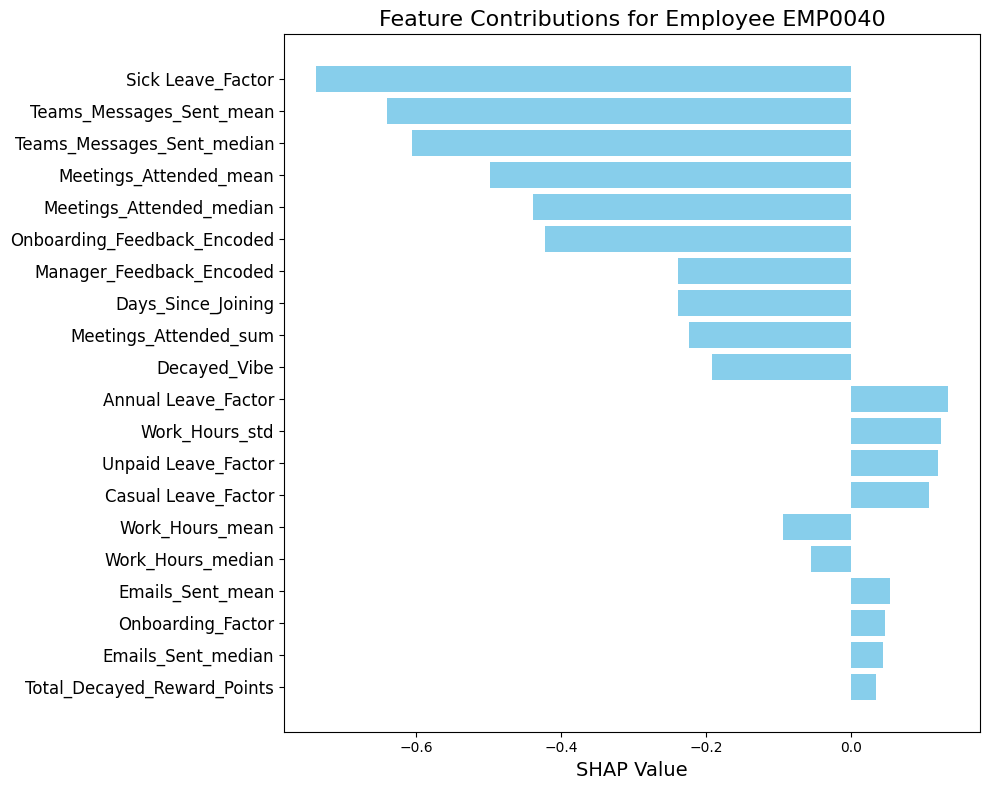

In [334]:
explainer = shap.TreeExplainer(isof)
shap_values = explainer.shap_values(X_scaled)

if isinstance(explainer.expected_value, (list, np.ndarray)) and len(explainer.expected_value) > 1:
    base_value = explainer.expected_value[0]
else:
    base_value = explainer.expected_value

if isinstance(shap_values, list):
    shap_array = shap_values[0]
else:
    shap_array = shap_values

print("X_scaled shape:", X_scaled.shape)
print("SHAP values shape:", shap_array.shape)
print("Number of features from our list:", len(features))

if shap_array.shape[1] != len(features):
    feature_names_force = [f"f{i}" for i in range(shap_array.shape[1])]
    print("Using default feature names for bar chart:", feature_names_force)
else:
    feature_names_force = features

anomalous_idx = np.where(anomaly_labels == -1)[0]
if len(anomalous_idx) > 0:
    idx = anomalous_idx[0]
    print(f"\nExplaining anomaly for Employee_ID: {df.loc[idx, 'Employee_ID']}")
    
    shap_instance = shap_array[idx, :]
    
    if shap_instance.shape[0] != len(features):
        feature_names_used = [f"f{i}" for i in range(shap_instance.shape[0])]
    else:
        feature_names_used = feature_names_force
    
    abs_shap = np.abs(shap_instance)
    sorted_idx = np.argsort(abs_shap)
    sorted_features = [feature_names_used[i] for i in sorted_idx]
    sorted_shap = shap_instance[sorted_idx]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_shap)), sorted_shap, align='center', color='skyblue')
    plt.yticks(range(len(sorted_shap)), sorted_features, fontsize=12)
    plt.xlabel("SHAP Value", fontsize=14)
    plt.title(f"Feature Contributions for Employee {df.loc[idx, 'Employee_ID']}", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No anomalies detected to explain.")

In [335]:
anomalous_features = {}

for idx in anomalous_idx:
    shap_instance = shap_array[idx, :]
    
    if shap_instance.shape[0] != len(features):
        feature_names_used = [f"f{i}" for i in range(shap_instance.shape[0])]
    else:
        feature_names_used = features
    
    negative_shap_indices = np.where(shap_instance < 0)[0]
    negative_shap_values = shap_instance[negative_shap_indices]
    sorted_neg_idx = np.argsort(negative_shap_values)  # Sort by most negative
    
    # Get the top 5 features with negative SHAP values
    top_5_neg_features = [feature_names_used[negative_shap_indices[i]] for i in sorted_neg_idx[:5]]
    
    # Store in dictionary with Employee_ID as key
    anomalous_features[df.loc[idx, 'Employee_ID']] = top_5_neg_features


In [336]:
af_db=pd.DataFrame()
af_db['Employee_ID']=anomalous_features.keys()
af_db['Problems']=anomalous_features.values()
af_db['Anamaly_Score']=np.array(anomalies['Anomaly_Score'])
af_db
af_db = af_db.sort_values(by='Anamaly_Score', ascending=True).reset_index(drop=True)
af_db

,Employee_ID,Problems,Anamaly_Score
0,EMP0418,"[Annual Leave_Factor, Meetings_Attended_mean, ...",-0.065163
1,EMP0056,"[Onboarding_Factor, Annual Leave_Factor, Teams...",-0.061345
2,EMP0108,"[Decayed_Vibe, Teams_Messages_Sent_mean, Teams...",-0.055268
3,EMP0384,"[Meetings_Attended_sum, Work_Hours_median, Tea...",-0.048464
4,EMP0300,"[Total_Decayed_Reward_Points, Casual Leave_Fac...",-0.043166
5,EMP0194,"[Total_Decayed_Reward_Points, Annual Leave_Fac...",-0.037859
6,EMP0040,"[Sick Leave_Factor, Teams_Messages_Sent_mean, ...",-0.032023
7,EMP0371,"[Unpaid Leave_Factor, Teams_Messages_Sent_medi...",-0.029659
8,EMP0205,"[Onboarding_Factor, Days_Since_Joining, Emails...",-0.028162
9,EMP0160,"[Sick Leave_Factor, Unpaid Leave_Factor, Onboa...",-0.021925
